In [0]:
#!pip install --upgrade torch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import model_zoo
from torchvision.models import vgg
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

In [0]:
# Подключение к Google Drive при помощи Oauth Access Token
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Класс по обработке Изображений
class ImageHandler:

    def __init__(self, image_size, content_image_path, style_image_path, device, preserve_colors=False):
        self.image_size = image_size
        self.device = device
        get_color_from_image_path = content_image_path if preserve_colors else None

        self.content_image = self.image_loader(content_image_path)
        self.style_image = self.image_loader(style_image_path, get_color_from_image_path)
        assert self.content_image.size() == self.style_image.size(), "The content and style image must be of the same size"

    def image_loader(self, image_path, get_color_from_image_path=None):
        loader = transforms.Compose([
            transforms.Resize(self.image_size),
            MatchColorHistogram(get_color_from_image_path),
            transforms.ToTensor()
        ])
        image = Image.open(image_path)
        image = loader(image).unsqueeze(0)
        return image.to(self.device, torch.float)

    def image_unloader(self, tensor):
        unloader = transforms.Compose([
            transforms.ToPILImage()
        ])
        image = tensor.cpu().clone()
        image = image.squeeze(0)
        return unloader(image)

    def imshow(self, tensor, title=None):
        image = self.image_unloader(tensor)
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.show()

In [0]:
# Histogram Color Matching Алгоритм для сохранения цвета исходного изображнения

class MatchColorHistogram(object):

    def __init__(self, color_from_image_path):
        self.color_from_image_path = color_from_image_path

    def __call__(self, image):
        if self.color_from_image_path is None:
            return image
        source_image = np.asarray(Image.open(self.color_from_image_path))/255.
        target_image = np.asarray(image)/255.

        mu_target = target_image.mean(axis=(0, 1))
        t = target_image - mu_target
        t = t.transpose(2, 0, 1).reshape(3, -1)
        sigma_target = t.dot(t.T) / t.shape[1]

        mu_source = source_image.mean(axis=(0, 1))
        s = source_image - mu_source
        s = s.transpose(2, 0, 1).reshape(3, -1)
        sigma_source = s.dot(s.T) / s.shape[1]

        chol_t = np.linalg.cholesky(sigma_target)
        chol_s = np.linalg.cholesky(sigma_source)
        ts = chol_s.dot(np.linalg.inv(chol_t)).dot(t)

        color_transferred_image = ts.reshape(*target_image.transpose(2, 0, 1).shape).transpose(1, 2, 0)
        color_transferred_image += mu_source
        color_transferred_image *= 255.
        color_transferred_image = np.clip(color_transferred_image, 0, 255)
        return Image.fromarray(color_transferred_image.astype('uint8'))

In [0]:
class TrainStyleImageHandler:

    def __init__(self, image_size, style_image_path, dataset_path, batch_size, device):
        self.image_size = image_size
        self.device = device

        train_dataset = datasets.ImageFolder(dataset_path, self.loader)
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size)

        self.style_image = self.style_image_loader(style_image_path, batch_size)

    @property
    def loader(self):
        return transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.CenterCrop(self.image_size),
            transforms.ToTensor(),
        ])

    def style_image_loader(self, style_image_path, batch_size):
        style_image = Image.open(style_image_path)
        style_image = self.loader(style_image)
        style_image = style_image.repeat(batch_size, 1, 1, 1)
        return style_image.to(self.device, torch.float)


In [0]:
# Функция-утилита, вернуть последний используемый Conv слой
def get_last_used_conv_layer(layer_names):
    layers = []
    for name in layer_names:
        a, b = name.split('_')[1:]
        layers.append((int(a), int(b)))
    return 'conv_%s_%s' % sorted(layers)[-1]

In [0]:
# Класс ConvPadded layer

class ConvPadded(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvPadded, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [0]:
# Класс Residual layer

class Residual(nn.Module):

    def __init__(self, channels):
        super(Residual, self).__init__()
        self.conv_1 = ConvPadded(channels, channels, kernel_size=3, stride=1)
        self.instance_norm_1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv_2 = ConvPadded(channels, channels, kernel_size=3, stride=1)
        self.instance_norm_2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.instance_norm_1(self.conv_1(x)))
        out = self.instance_norm_2(self.conv_2(out))
        return out + x

In [0]:
# Класс UpsampleConv layer

class UpsampleConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample):
        super(UpsampleConv, self).__init__()
        self.upsample_layer = nn.Upsample(mode='nearest', scale_factor=upsample)
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.upsample_layer(x)
        out = self.reflection_pad(out)
        return self.conv2d(out)

In [0]:
# Класс Normalization layer, нормализация изображения для VGG19

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [0]:
class TransformNetwork(nn.Module):

    def __init__(self):
        super(TransformNetwork, self).__init__()
        # initial layers
        self.conv_1 = ConvPadded(3, 32, kernel_size=9, stride=1)
        self.instance_norm_1 = nn.InstanceNorm2d(32, affine=True)
        self.conv_2 = ConvPadded(32, 64, kernel_size=3, stride=2)
        self.instance_norm_2 = nn.InstanceNorm2d(64, affine=True)
        self.conv_3 = ConvPadded(64, 128, kernel_size=3, stride=2)
        self.instance_norm_3 = nn.InstanceNorm2d(128, affine=True)
        # residual layers
        self.residual_1 = Residual(128)
        self.residual_2 = Residual(128)
        self.residual_3 = Residual(128)
        self.residual_4 = Residual(128)
        self.residual_5 = Residual(128)
        # upsampling layers
        self.deconv_1 = UpsampleConv(128, 64, kernel_size=3, stride=1, upsample=2)
        self.instance_norm_4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv_2 = UpsampleConv(64, 32, kernel_size=3, stride=1, upsample=2)
        self.instance_norm_5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv_3 = ConvPadded(32, 3, kernel_size=9, stride=1)

        # non linear layer
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.instance_norm_1(self.conv_1(x)))
        out = self.relu(self.instance_norm_2(self.conv_2(out)))
        out = self.relu(self.instance_norm_3(self.conv_3(out)))

        out = self.residual_1(out)
        out = self.residual_2(out)
        out = self.residual_3(out)
        out = self.residual_4(out)
        out = self.residual_5(out)

        out = self.relu(self.instance_norm_4(self.deconv_1(out)))
        out = self.relu(self.instance_norm_5(self.deconv_2(out)))
        out = self.deconv_3(out)

        return out

In [0]:
class TransferVgg(nn.Module):

    def __init__(self, layers):
        super(TransferVgg, self).__init__()
        self.layer_names = []
        for layer_name, layer in layers:
            setattr(self, layer_name, layer)
            self.layer_names.append(layer_name)

    def forward(self, x, out_keys):
        out = {}
        for layer_name in self.layer_names:
            layer = getattr(self, layer_name)
            if isinstance(layer, nn.Conv2d):
                out[layer_name] = F.relu(layer(x))
            else:
                out[layer_name] = layer(x)
            x = out[layer_name]
        return {key: value for key, value in out.items() if key in out_keys}

    @classmethod
    def factory(cls, cfg, last_layer, mean, std):
        layers = [('normalization', Normalization(mean, std))]
        in_channels = 3
        conv_layer = 1
        conv_layer_number = 1
        pool_layer_number = 1
        for v in cfg:
            if v == 'M':
                layers.append(('pool_%s' % pool_layer_number, nn.MaxPool2d(kernel_size=2, stride=2)))
                pool_layer_number += 1
                conv_layer += 1
                conv_layer_number = 1
            else:
                conv_layer_name = 'conv_%s_%s' % (conv_layer, conv_layer_number)
                layers.append((conv_layer_name, nn.Conv2d(in_channels,
                                                          v,
                                                          kernel_size=3,
                                                          padding=1)))
                in_channels = v
                if conv_layer_name == last_layer:
                    break
                conv_layer_number += 1
        return cls(layers)

In [0]:
def transfer_vgg19(last_layer, device):
        mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).to(device)
       
        model = TransferVgg.factory(cfg=vgg.cfgs['E'], last_layer=last_layer, mean=mean, std=std)
        
        state_dict = model_zoo.load_url(vgg.model_urls['vgg19'], model_dir="/content/gdrive/My Drive", progress=True)

        mapping = {
            'conv_1_1': 'features.0',
            'conv_1_2': 'features.2',
            'conv_2_1': 'features.5',
            'conv_2_2': 'features.7',
            'conv_3_1': 'features.10',
            'conv_3_2': 'features.12',
            'conv_3_3': 'features.14',
            'conv_3_4': 'features.16',
            'conv_4_1': 'features.19',
            'conv_4_2': 'features.21',
            'conv_4_3': 'features.23',
            'conv_4_4': 'features.25',
            'conv_5_1': 'features.28',
            'conv_5_2': 'features.30',
            'conv_5_3': 'features.32',
            'conv_5_4': 'features.34',
        }

        new_state_dict = {}
        for key, map_to in mapping.items():
            new_state_dict['%s.weight' % key] = state_dict['%s.weight' % map_to]
            new_state_dict['%s.bias' % key] = state_dict['%s.bias' % map_to]
            if key == last_layer:
                break
        model.load_state_dict(new_state_dict)
        for param in model.parameters():
            param.requires_grad = False
        return model.to(device).eval()

In [0]:
# Класс функции потерь для контента

class ContentLoss(nn.Module):

    def __init__(self, weight):
        super(ContentLoss, self).__init__()
        self.weight = weight

    def forward(self, input, target):
        return self.weight * F.mse_loss(input, target)


In [0]:
# Класс функции потерь для стиля

class StyleLoss(nn.Module):

    def __init__(self, weight):
        super(StyleLoss, self).__init__()
        self.weight = weight

    def forward(self, input, target):
        G_input = self.gram_matrix(input)
        G_target = self.gram_matrix(target).detach()
        return self.weight * F.mse_loss(G_input, G_target)
  # Матрица Грама

    def gram_matrix(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)

In [0]:
# Класс функции потерь для Total variation Loss

class VariationLoss(nn.Module):

    def __init__(self, weight):
        super(VariationLoss, self).__init__()
        self.weight = weight

    def forward(self, input):
        batch_size, n_channels, image_height, image_width = input.size()
        a = input[:, :, :image_height-1, :image_width-1] - input[:, :, 1:, :image_width-1]

        b = input[:, :, :image_height-1, :image_width-1] - input[:, :, :image_height-1, 1:]
        return self.weight * torch.sum((a**2 + b**2).pow(1.25))

In [0]:
# Выбор основного устройства CPU или GPU (CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
writer = SummaryWriter('runs')

image_handler = ImageHandler(image_size=600,
                                 content_image_path="/content/gdrive/My Drive/maple.jpg",
                                 style_image_path="/content/gdrive/My Drive/fractal.jpg",
                                 device=device,
                                 preserve_colors=False)
content_layer_names = ['conv_4_2']
style_layer_names = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']
layer_names = content_layer_names + style_layer_names

last_layer = get_last_used_conv_layer(layer_names)
model = transfer_vgg19(last_layer, device)

print('Model:' , model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Model: TransferVgg(
  (normalization): Normalization()
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_4_1): Conv2d(256, 512, ker

In [0]:
content_layers = ['conv_4_2']
style_layers = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']

content_weights = [float(w) for w in '1'.split(',')]
if len(content_weights) == 1:
  content_weights = [content_weights[0]] * len(content_layers)
else:
  assert len(content_weights) == len(content_layers)
content_layers_weights = {n: w for n, w in zip(content_layers, content_weights)}

style_weights = [float(w) for w in '64000,128000,256000,512000,512000'.split(',')]
if len(style_weights) == 1:
  style_weights = [style_weights[0]] * len(style_layers)
else:
  assert len(style_weights) == len(style_layers)
style_layers_weights = {n: w for n, w in zip(style_layers, style_weights)}

In [0]:
content_features = model(image_handler.content_image, content_layer_names)

content_losses = {layer_name: ContentLoss(weight=weight)
                    for layer_name, weight in content_layers_weights.items()}

style_features = model(image_handler.style_image, style_layer_names)

style_losses = {layer_name: StyleLoss(weight=weight)
                    for layer_name, weight in style_layers_weights.items()}

variation_loss = VariationLoss(weight=0.0001)

combination_image = image_handler.content_image.clone()
optimizer = optim.LBFGS([combination_image.requires_grad_()])

run [1]:
Style Loss : 607.644043 Content Loss: 0.000000 Variation Loss: 2.244196
run [2]:
Style Loss : 607.628479 Content Loss: 0.000000 Variation Loss: 2.244193
run [3]:
Style Loss : 604.210205 Content Loss: 0.017125 Variation Loss: 2.243659
run [4]:
Style Loss : 555.939148 Content Loss: 1.846377 Variation Loss: 2.237389
run [5]:
Style Loss : 486.202942 Content Loss: 5.720706 Variation Loss: 2.260732
run [6]:
Style Loss : 415.869720 Content Loss: 10.132613 Variation Loss: 2.392681
run [7]:
Style Loss : 354.424561 Content Loss: 14.206765 Variation Loss: 2.622423
run [8]:
Style Loss : 305.701874 Content Loss: 18.007465 Variation Loss: 2.837221
run [9]:
Style Loss : 259.340363 Content Loss: 19.702332 Variation Loss: 2.878319
run [10]:
Style Loss : 209.143600 Content Loss: 19.538095 Variation Loss: 2.767527
run [11]:
Style Loss : 177.302826 Content Loss: 20.452957 Variation Loss: 2.699495
run [12]:
Style Loss : 154.204163 Content Loss: 22.145166 Variation Loss: 2.717119
run [13]:
Style Lo

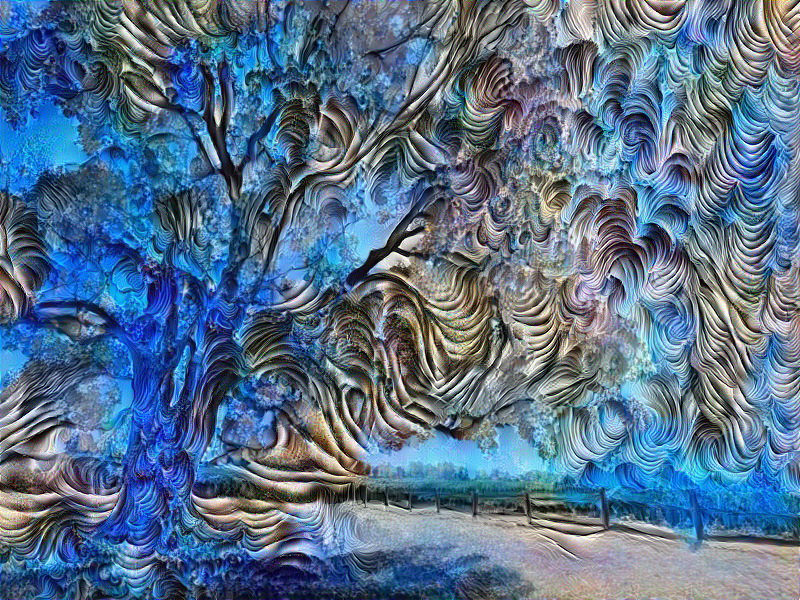

In [0]:
# Итерационный процесс

run = [0]
while run[0] <= 700:
    def closure():
        # Коррекция значений пикселей изображения, приведение к (0, 1)
        combination_image.data.clamp_(0, 1)
        # Обнуление градиентов
        optimizer.zero_grad()
        out = model(combination_image, layer_names)
        variation_score = variation_loss(combination_image)
        content_score = torch.sum(torch.stack([loss(out[layer_name], content_features[layer_name].detach())
                                                for layer_name, loss in content_losses.items()]))
        style_score = torch.sum(torch.stack([loss(out[layer_name], style_features[layer_name].detach())
                                                for layer_name, loss in style_losses.items()]))

        # Итоговая функция потерь

        loss = style_score + content_score + variation_score

        # Backpropogation
        loss.backward()

        run[0] += 1
        print("run {}:".format(run))
        print('Style Loss : {:4f} Content Loss: {:4f} Variation Loss: {:4f}'.format(style_score.item(), content_score.item(), variation_score.item()))
        writer.add_scalar('Content Loss',
                        content_score,
                        run[0])
        writer.add_scalar('Style Loss',
                        style_score,
                        run[0])
        writer.add_scalar('Loss',
                        loss,
                        run[0])
        if run[0] % 50 == 0:
          torchvision.utils.save_image(combination_image, "/content/gdrive/My Drive/fractal_{}.png".format(str(run)[1:-1]))
          print('Image Saved:' ,"{}.jpg".format(run))
        
        return loss

    optimizer.step(closure)

# Коррекция значений пикселей изображения, приведение к (0, 1)
combination_image.data.clamp_(0, 1)

torchvision.utils.save_image(combination_image, "/content/gdrive/My Drive/fractal_{}.png".format("Final_nst"))

image_handler.image_unloader(combination_image)